In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
from functools import partial, reduce
from funcy import compose
import numpy as np
from parametric_pde_find import *
from scipy.integrate import odeint
from scipy.stats import wilcoxon, ranksums, mannwhitneyu, friedmanchisquare
from scipy.signal import savgol_filter
from numpy.fft import fft, ifft, fftfreq
from robust_pde_diff import DLrSR, RobustPCA, DLrSR_para
from para_UBIC import *
from best_subset import *
from solvel0 import solvel0
# from okridge.solvel0 import okridge_solvel0, okridge_solvel0_full

from findiff import FinDiff
from abess.linear import LinearRegression
from sklearn.linear_model import BayesianRidge, ARDRegression, Ridge, Lasso
from sklearn.utils.random import sample_without_replacement
from UBIC import fit_blr, UBIC, decreasing_values_indices
from skscope_tools import best_subset_all_solutions, abess_all_solutions

from tqdm import tqdm
import getpass

fontsize = 20 # for plots

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Sklearn's version: 1.5.1


In [2]:
def ks_rhs(u, t, params):
    k, L, x = params
    a = (1 + 0.25*np.sin(x*2*np.pi/L))  # uu_x
    b = -1 + 0.25*np.exp(-(x-2)**2/5)   # u_{xx}
    c = -1 - 0.25*np.exp(-(x+2)**2/5)   # u_{xxxx}
    deriv = a*u*ifft(1j*k*fft(u)) + b*ifft(-k**2*fft(u)) + c*ifft(k**4*fft(u))
    return real(deriv)

In [3]:
# Set size of grid
n = 512
m = 512
L = 20
max_time = 200

# Set up grid
x = np.linspace(-L,L,n+1)[:-1]; dx = x[1]-x[0]
t = np.linspace(0,max_time,2*m); dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
u0 = np.exp(-(x)**2)

# Solve with time dependent uu_x term
params = (k,L,x)
# u_full = odeint(ks_rhs, u0, t, args=(params,)).T
u_full = np.load("./Datasets/ks_u_full.npy")

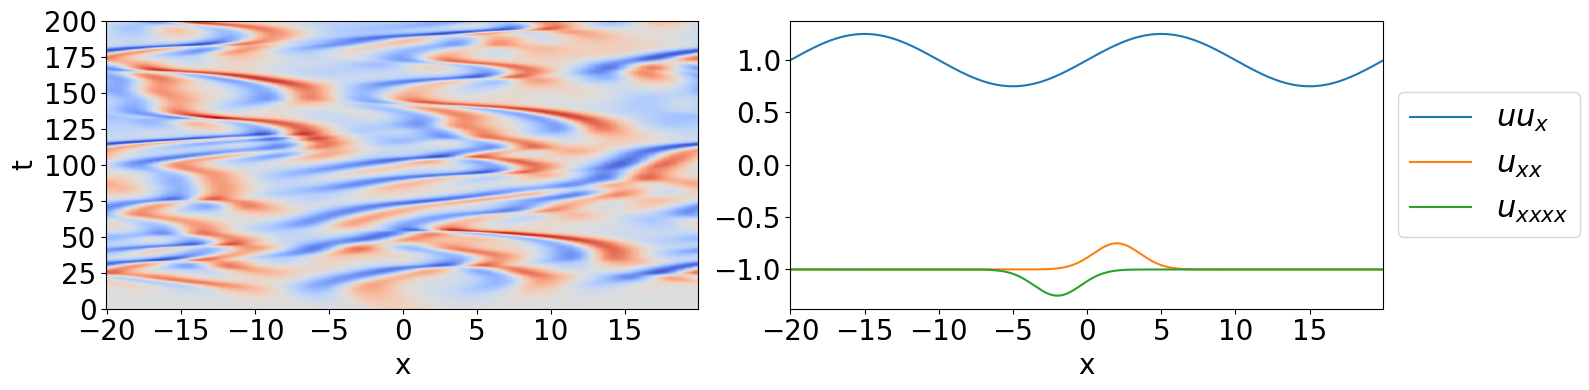

In [4]:
# Plot
fig = figure(figsize=(16, 4))
X, T = np.meshgrid(x, t)

subplot(1,2,1)
pcolor(X, T, u_full.T, cmap=cm.coolwarm)
xlabel('x', fontsize = fontsize)
ylabel('t', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)

uu_x_true = 1 + 0.25*np.sin(x*2*np.pi/L)
u_xx_true = -1 + 0.25*np.exp(-(x-2)**2/5)
u_4x_true = -1 - 0.25*np.exp(-(x+2)**2/5)

subplot(1,2,2)
plot(x, uu_x_true, label = r'$uu_x$')
plot(x, u_xx_true, label = r'$u_{xx}$')
plot(x, u_4x_true, label = r'$u_{xxxx}$')
xlim([x[0],x[-1]])

xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlabel('x', fontsize = fontsize)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
fig.tight_layout()
plt.show()

In [5]:
# u = u_full[:,-m:]
# t = t[-m:]
u = u_full[:,:m]
t = t[:m]

In [6]:
noise_lv = 0.01
np.random.seed(0)
u = u + noise_lv*0.01*std(u)*np.random.randn(n,m)

is_denoising = True
if is_denoising and noise_lv > 0:
    window_size = 15
    poly_order = 2
    u = savgol_filter(u, window_size, poly_order, axis=0)

alpha = 3e-4
diff_kwargs = {"kind": "kalman", "alpha": alpha}
Ut, Theta, Ut_grouped, Theta_grouped, rhs_des = construct_group_linear_system(u, x, t, 
                                                                              diff_kwargs, 
                                                                              D=3, 
                                                                              include_bias=False)

In [7]:
# Theta_grouped = np.array([real(Theta[n*np.arange(m)+j,:]) for j in range(n)])
# Ut_grouped = np.array([real(Ut[n*np.arange(m)+j]) for j in range(n)])
fft_percent = 90
fft_Theta_grouped = np.array([remove_f(fft(Theta_grouped[:, :, k]), fft_percent) 
                              for k in range(Theta_grouped.shape[-1])])
fft_Theta_grouped = np.moveaxis(fft_Theta_grouped, 0, -1)
fft_Ut_grouped = remove_f(fft(Ut_grouped[:, :, 0]), fft_percent)
fft_Ut_grouped = np.expand_dims(fft_Ut_grouped, -1)

In [8]:
# Solve and plot
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped)
xi = Xi[np.argmin(Losses)]

0 u
1 u^2
3 u_x
4 u_xx
5 u_xxx
6 uu_x
7 uu_xx
8 uu_xxx
10 u^2u_xx


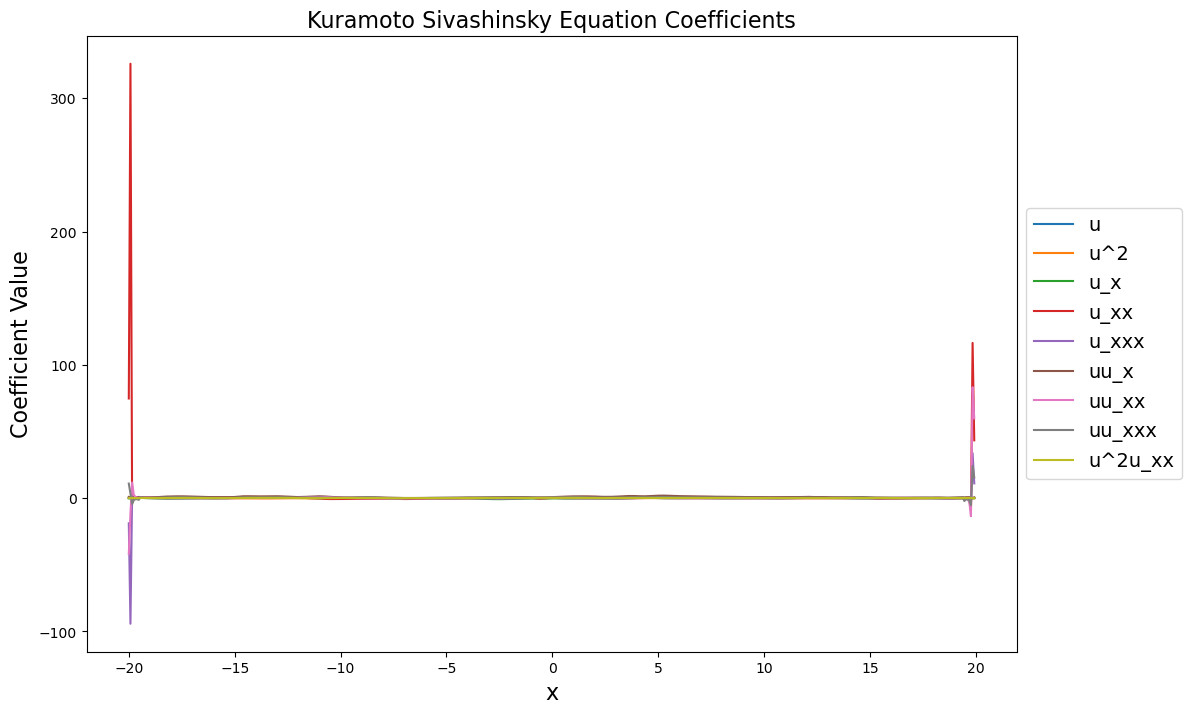

In [9]:
pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        print(j, rhs_des[j])
        plot(x, xi[j,:], label = rhs_des[j])
                
title('Kuramoto Sivashinsky Equation Coefficients', fontsize = 16)
xlabel('x', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
plt.show()
# mse_clean_sgtr = Norm(xi-xi_true[:,wx:-wx])**2/(m*len(rhs_des))
# print('MSE: ', mse_clean_sgtr)

In [10]:
support_sizes = []
for xi in Xi:
    support_sizes.append(len(np.where(np.linalg.norm(xi, axis=-1) > 1e-10)[0]))
support_sizes = np.array(support_sizes)

unique_s = {}
for s,l in zip(support_sizes, Losses):
    if s not in unique_s:
        unique_s[s] = l
    else:
        unique_s[s] = min(unique_s[s], l)

iterations = [i+1 for i in range(len(Losses))]
xticks1 = [1] + [i+1 for i in range(len(Losses)) if (i+1)%5 == 0]

In [11]:
kk = [k for k, v in sorted(unique_s.items())]
vv = [v for k, v in sorted(unique_s.items())]
unique_complete = {19: -3018002.653783615,
 16: -3018008.3104714397,
 13: -3018013.9887174764,
 11: -3018017.763408803,
 9: -3018021.268350686,
 7: -3018024.419589371,
 6: -3018026.034282218,
 5: -3018027.5608514636,
 4: -3018028.723991324,
 3: -3018026.8797664624,
 2: -3017863.0623463537,
 1: -3017858.965242139}
kkc = [k for k, v in sorted(unique_complete.items())]
vvc = [v for k, v in sorted(unique_complete.items())]
xticks2 = sorted(set(kk).union(set(kkc)))

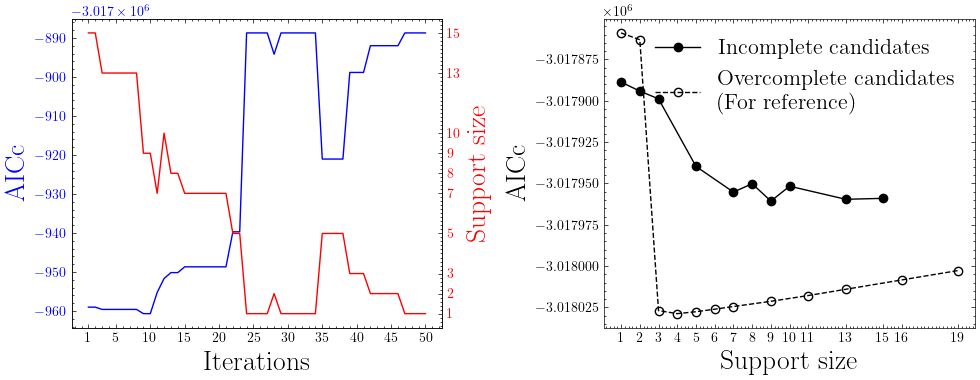

In [12]:
import scienceplots
fs = 20
with plt.style.context('science'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    color = 'blue'
    ax1.set_xlabel('Iterations', fontsize=fs)
    ax1.set_ylabel('AICc', color=color, fontsize=fs)
    ax1.plot(iterations, Losses, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xticks(xticks1)
    # ax1.set_title(f"$\epsilon$ = {noise_lv}", fontsize=fs)

    ax1p = ax1.twinx()
    color = 'red'
    ax1p.set_ylabel('Support size', color=color, fontsize=fs)
    ax1p.plot(iterations, support_sizes, color=color)
    ax1p.tick_params(axis='y', labelcolor=color)
    ax1p.set_yticks(np.array(list(unique_s.keys())))
    
    
    ax2.plot(kk, vv, '-o', color='black', label='Incomplete candidates')
    ax2.plot(kkc, vvc, '--o', color='black', markerfacecolor='none', label='Overcomplete candidates\n(For reference)')
    ax2.set_xticks(xticks2)
#     ax2.hlines(PDE_FIND_Loss(normalized_Theta_grouped, normalized_Ut_grouped, est_true_xi), 
#                1, 19, linestyles='--', color='red', label="AICc of the true model (support size = 2)")
    ax2.set_ylabel("AICc", fontsize=fs)
    ax2.set_xlabel("Support size", fontsize=fs)
    # ax2.set_title(f"$\epsilon$ = {noise_lv}", fontsize=fs)
    ax2.legend(fontsize=16, loc='upper right')
    fig.tight_layout()
    plt.savefig(f"/Users/pongpisitthanasutives/Documents/latex/ML4PS/figures/ks_incomplete_sgtr_noise0-01.pdf")
    plt.savefig(f"/Users/pongpisitthanasutives/Documents/latex/ML4PS/figures/ks_incomplete_sgtr_noise0-01.png", dpi=300)
    plt.show()

In [13]:
candidates = set()
max_complexity = 10 # X_weak.shape[-1]

normalized_Theta_grouped, normalized_Ut_grouped = normalize_groups(Theta_grouped, 
                                                                   Ut_grouped, 
                                                                   2)

counter = {0}; i = 0
max_counter = 30
while True:
    bs_i = solvel0(normalized_Theta_grouped[i], 
                   normalized_Ut_grouped[i], 
                   max_complexity=max_complexity, 
                   miosr=True, refine=True, verbose=False)
    
#     bs_i = best_subset_all_solutions(normalized_Theta_grouped[i], 
#                                      normalized_Ut_grouped[i], 
#                                      sparsity=max_complexity, 
#                                      refine=True)[1]
    
#     bs_i = abess_all_solutions(normalized_Theta_grouped[i], 
#                                      normalized_Ut_grouped[i], 
#                                      sparsity=max_complexity, 
#                                      refine=True)[1]

#     _, bs_i = okridge_solvel0_full(Theta_grouped[i], Ut_grouped[i], k=max_complexity)
    
    bs_i = list(map(tuple, bs_i))
    candidates = candidates.union(bs_i)
    
    if len(counter) == max_counter: break
        
    print(len(counter))
    i = np.random.choice(len(Theta_grouped))
    while i in counter:
        i = np.random.choice(len(Theta_grouped))
    counter.add(i)

candidates

Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-17
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


{(0, 1, 2, 3, 4, 5, 6, 8),
 (0, 1, 2, 3, 4, 5, 6, 8, 9, 10),
 (0, 1, 2, 3, 4, 5, 6, 8, 9, 11),
 (0, 1, 2, 3, 4, 6, 7, 8, 9),
 (0, 1, 2, 3, 4, 6, 7, 8, 9, 12),
 (0, 1, 2, 3, 4, 6, 8, 9, 10),
 (0, 1, 2, 3, 6, 7, 8, 10, 11, 12),
 (0, 1, 2, 3, 6, 7, 10),
 (0, 1, 2, 3, 6, 7, 10, 11, 12),
 (0, 1, 2, 3, 6, 7, 10, 12),
 (0, 1, 2, 4, 5, 6, 8, 10, 11, 14),
 (0, 1, 2, 4, 5, 7, 9, 11, 12, 13),
 (0, 1, 2, 4, 6, 8, 10, 12),
 (0, 1, 2, 4, 6, 8, 10, 12, 14),
 (0, 1, 2, 6, 8, 9, 10, 11, 12, 13),
 (0, 1, 2, 6, 8, 10, 11, 14),
 (0, 1, 3, 4, 5, 6),
 (0, 1, 3, 4, 5, 6, 7, 8, 9, 10),
 (0, 1, 3, 4, 5, 6, 7, 8, 10),
 (0, 1, 3, 4, 5, 6, 7, 8, 10, 14),
 (0, 1, 3, 4, 5, 6, 7, 9, 11, 13),
 (0, 1, 3, 4, 5, 6, 8),
 (0, 1, 3, 4, 5, 6, 8, 10),
 (0, 1, 3, 4, 5, 6, 8, 10, 11, 13),
 (0, 1, 3, 4, 6, 7, 8, 9),
 (0, 1, 3, 4, 6, 7, 8, 9, 12),
 (0, 1, 3, 4, 6, 7, 8, 10, 11, 12),
 (0, 1, 3, 4, 6, 7, 8, 10, 12),
 (0, 1, 3, 4, 6, 7, 9, 11, 13),
 (0, 1, 4, 5, 6, 7),
 (0, 1, 4, 5, 6, 7, 8),
 (0, 1, 4, 5, 6, 7, 8, 10),
 (0, 1, 4, 

In [14]:
lam = 0
for j in range(len(Ut_grouped)):
    est_xi = Ridge(alpha=0, fit_intercept=False).fit(Theta_grouped[j], Ut_grouped[j]).coef_.reshape(-1, 1)
    difference = Ut_grouped[j] - Theta_grouped[j].dot(est_xi)
    lam += (np.linalg.norm(difference, 2)**2)/(np.linalg.norm(est_xi, 2)**2)
lam /= len(Ut_grouped)
print("lam:", lam)

track = {}
for indices in tqdm(candidates):
    com = len(indices)
    rss = 0
    for j in range(len(Ut_grouped)):
        est_xi = Ridge(alpha=lam, fit_intercept=False).fit(Theta_grouped[j][:, indices], Ut_grouped[j]).coef_.reshape(-1, 1)
        difference = fft_Ut_grouped[j] - fft_Theta_grouped[j][:, indices].dot(est_xi)
        rss += np.linalg.norm(difference, 2)**2 + lam*np.linalg.norm(est_xi, 2)**2
    if com not in track or track[com][1] > rss:
        track[com] = indices, rss

candidates = set([e[0] for e in list(track.values())])
candidates

lam: 15.516288050153223


100%|██████████████████████████████████████████████████| 181/181 [00:39<00:00,  4.54it/s]


{(0, 1, 3, 4, 5, 6, 7, 8, 9, 10),
 (0, 1, 3, 4, 5, 6, 7, 8, 10),
 (0, 1, 3, 4, 5, 6, 8, 10),
 (0, 3, 4, 5, 6),
 (0, 3, 4, 6),
 (0, 3, 4, 6, 8, 9, 10),
 (0, 3, 4, 6, 8, 10),
 (0, 4, 6),
 (3, 6),
 (6,)}

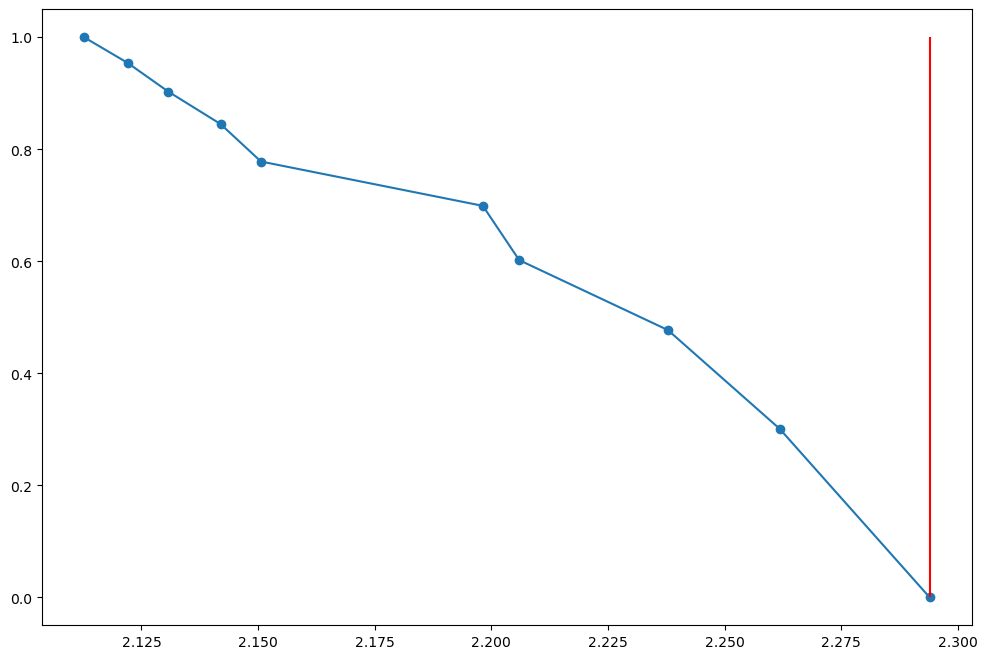

In [15]:
log_errors = []
log_coms = []
for indices in sorted(candidates, key=len):
    com = len(indices)
    rss = 0
    for j in range(len(Ut_grouped)):
        est_xi = SkLinearRegression(fit_intercept=False).fit(Theta_grouped[j][:, indices], Ut_grouped[j]).coef_.reshape(-1, 1)
        difference = Ut_grouped[j] - Theta_grouped[j][:, indices].dot(est_xi)
        rss += np.sum(difference**2)
    log_error = np.log10(np.sqrt(rss))
    log_com = np.log10(com)
    log_errors.append(log_error)
    log_coms.append(log_com)
plt.plot(log_errors, log_coms, '-o')
# interp_method='interp1d' or polynomial_degree=3 do not work here.
plt.vlines(find_corner(log_errors, log_coms, interp_method='polynomial', polynomial_degree=2), 
           ymin=min(log_coms), ymax=max(log_coms), color='red')
plt.show()

aic: 10 6
bic: 10 6


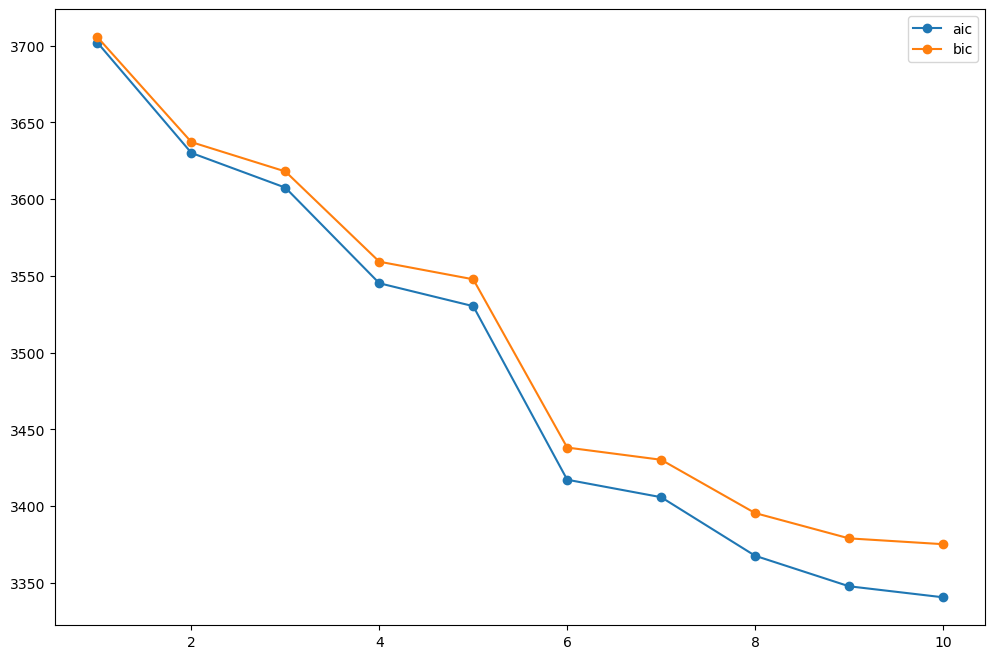

In [16]:
time_integrator = lambda _: _
time_integrator = partial(trapz, axis=0)
# psd = lambda _: np.expand_dims(power_spectral_density(_[:, :, 0]), -1)
psd = partial(power_spectral_density, axis=1)
time_integrator = compose(time_integrator, psd)
ic_scores = {}
for indices in candidates:
    est_xi = np.zeros((Theta_grouped[0].shape[-1], len(Ut_grouped)))
    for j in range(len(Theta_grouped)):
        est_xi[indices, j:j+1] = np.linalg.lstsq(Theta_grouped[j][:, indices], Ut_grouped[j], rcond=None)[0]

    Ut_grouped_est = estimate_Ut_grouped_est(Theta_grouped, est_xi)
    rss = rss_group(Ut_grouped_est, Ut_grouped, time_integrator)
    # N = np.prod(Ut_grouped.shape)
    N = np.prod(time_integrator(Ut_grouped).shape)
    k = len(np.where(np.linalg.norm(est_xi, axis=-1)>0)[0])
    
    # aic = PDE_FIND_Loss(Theta_grouped, Ut_grouped, est_xi)
    # bic = BIC_Loss(Theta_grouped, Ut_grouped, est_xi)
    aic = N*np.log(2*np.pi*rss/N+1e-5) + 2*k+(2*k**2+2*k)/(N-k-1)
    bic = N*np.log(2*np.pi*rss/N+1e-5) + np.log(N)*k
    
    if len(indices) not in ic_scores: ic_scores[len(indices)] = (aic, bic, indices)
    elif aic < ic_scores[len(indices)][0]: ic_scores[len(indices)] = (aic, bic, indices)

com_ics = sorted([(len(e[2]), e[0], e[1]) for e in list(ic_scores.values())])
complexities = [e[0] for e in com_ics]
aics = [e[1] for e in com_ics]
bics = [e[2] for e in com_ics]

print("aic:", complexities[np.argmin(aics)], find_corner(complexities, aics))
print("bic:", complexities[np.argmin(bics)], find_corner(complexities, bics))
plt.plot(complexities, aics, '-o', label='aic')
plt.plot(complexities, bics, '-o', label='bic'); plt.legend(); plt.show()

In [17]:
best_subsets = {}
for indices in candidates:
    est_xi = []
    uncert = 0.0
    rss = 0.0
    for j in trange(0, len(Theta_grouped), 1):        
        # model = Ridge(alpha=lam, fit_intercept=False)
        # model = BayesianRidge(fit_intercept=False)
        model = ARDRegression(fit_intercept=False)
        model.fit(Theta_grouped[j][:, indices], Ut_grouped[j].flatten())
        post_prediction = (fft_Theta_grouped[j][:, indices]@model.coef_).reshape(-1, 1)
        rss = rss + np.linalg.norm(fft_Ut_grouped[j] - post_prediction, 'fro')**2
        
        coeff = model.coef_.reshape(-1, 1)
        uncert = uncert + np.sqrt(np.diag(model.sigma_)).sum()/abs(model.coef_).sum()
        est_xi.append(coeff)
        
    if len(indices) not in best_subsets: best_subsets[len(indices)] = (rss, uncert, indices)
    elif rss < best_subsets[len(indices)][0]: best_subsets[len(indices)] = (rss, uncert, indices)

100%|████████████████████████████████████████████████| 512/512 [00:00<00:00, 2285.30it/s]


In [18]:
complexities = sorted(best_subsets.keys())

min_uncert = np.min([best_subsets[com][1] for com in best_subsets])
uncertainties = []
for com in complexities:
    _, uncert, _ = best_subsets[com]
    uncert = uncert/min_uncert
    uncertainties.append(uncert)
uncertainties = np.array(uncertainties)

nfft = None; return_onesided = False
# ground_periogram = periodogram(ifft(fft_Ut_grouped[:, :, 0]), nfft=nfft, axis=-1)[1]
ground_periogram = periodogram(Ut_grouped[:, :, 0], return_onesided=return_onesided)[1]

10


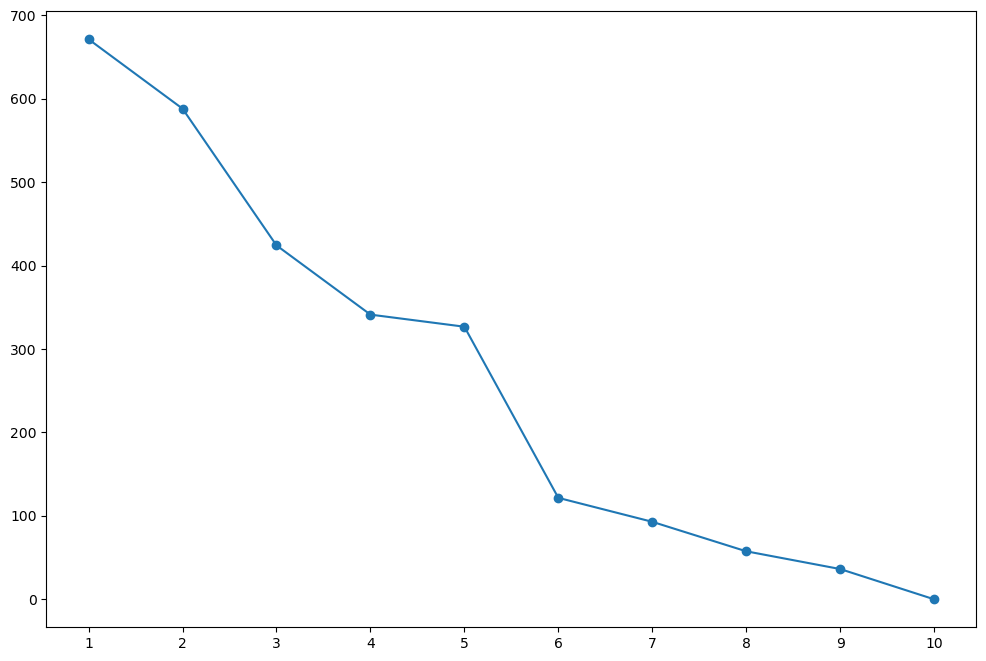

In [19]:
epsilon = 1e-5
time_integrator = lambda _: _
time_integrator = partial(trapz, axis=1)
threshold_lambda = 1e6
ics = []
rss_list = []
for com in complexities:
    vbics = []
    est_xi = np.zeros((fft_Theta_grouped[0].shape[-1], len(fft_Ut_grouped)))
    eff_indices = best_subsets[com][-1]
    for j in range(len(Theta_grouped)):
#         est_xi[eff_indices, j:j+1] = BayesianRidge(fit_intercept=False).fit(Theta_grouped[j][:, eff_indices], 
#                                                                             Ut_grouped[j].flatten()).coef_.reshape(-1, 1)
        ARD = ARDRegression(threshold_lambda=threshold_lambda, fit_intercept=False).fit(Theta_grouped[j][:, eff_indices], 
                                                                                        Ut_grouped[j].flatten())
        assert com == np.count_nonzero(ARD.coef_)
        est_xi[eff_indices, j:j+1] = ARD.coef_.reshape(-1, 1)
#         est_xi[eff_indices, j:j+1] = np.linalg.lstsq(Theta_grouped[j][:, eff_indices], 
#                                                      Ut_grouped[j], 
#                                                      rcond=None)[0]
#         post_prediction = fft_Theta_grouped[j][:, eff_indices]@(est_xi[eff_indices, j:j+1])
#         post_prediction = periodogram(ifft(post_prediction.flatten()))[1]
#         ground = periodogram(ifft(fft_Ut_grouped[j].flatten()))[1]
        post_prediction = Theta_grouped[j][:, eff_indices]@(est_xi[eff_indices, j:j+1])
        post_prediction = periodogram(post_prediction.T, return_onesided=return_onesided)[1]
        ground = periodogram(Ut_grouped[j].T, return_onesided=return_onesided)[1]
        rss = np.linalg.norm(ground - post_prediction, 2)**2
        # vbics.append(rss2bic(rss, com+uncertainties[com-1], len(post_prediction), epsilon))
        vbics.append(rss2bic(rss, com, len(post_prediction), epsilon))
        
    # pred_group = ifft(prediction_group(fft_Theta_grouped, est_xi))
    # pred_periogram = periodogram(pred_group, nfft=nfft, axis=axis)[1]
    pred_group = prediction_group(Theta_grouped, est_xi)
    pred_periogram = periodogram(pred_group, return_onesided=return_onesided)[1]
    diff_periogram = time_integrator(ground_periogram)-time_integrator(pred_periogram)
    res = np.vstack([diff_periogram[j] for j in range(len(diff_periogram))])
    nobs = np.prod(diff_periogram.shape)
    rss = np.linalg.norm(res, ord='fro')**2
    ics.append(nobs*np.log(2*np.pi*rss/nobs+epsilon) + np.log(nobs)*com)
    rss_list.append(rss)
    
print(np.argmin(ics)+1)
plt.plot(complexities, ics-min(ics), '-o')
plt.xticks(complexities)
plt.show()

In [20]:
varying_bics = []
pvalues = [0.0]
for eff_indices in sorted(candidates, key=len):
    vbics = []
    est_xi = np.zeros((fft_Theta_grouped[0].shape[-1], len(fft_Ut_grouped)))
    com = len(eff_indices)
    for j in range(len(Theta_grouped)):
#         est_xi[eff_indices, j:j+1] = BayesianRidge(fit_intercept=False).fit(Theta_grouped[j][:, eff_indices], 
#                                                                             Ut_grouped[j].flatten()).coef_.reshape(-1, 1)
        ARD = ARDRegression(threshold_lambda=threshold_lambda, fit_intercept=False).fit(Theta_grouped[j][:, eff_indices], 
                                                                                        Ut_grouped[j].flatten())
        assert com == np.count_nonzero(ARD.coef_)
        est_xi[eff_indices, j:j+1] = ARD.coef_.reshape(-1, 1)
#         est_xi[eff_indices, j:j+1] = np.linalg.lstsq(Theta_grouped[j][:, eff_indices], 
#                                                      Ut_grouped[j], 
#                                                      rcond=None)[0]
#         post_prediction = fft_Theta_grouped[j][:, eff_indices]@(est_xi[eff_indices, j:j+1])
#         post_prediction = periodogram(ifft(post_prediction.flatten()))[1]
#         ground = periodogram(ifft(fft_Ut_grouped[j].flatten()))[1]
        post_prediction = Theta_grouped[j][:, eff_indices]@(est_xi[eff_indices, j:j+1])
        post_prediction = periodogram(post_prediction.T, return_onesided=return_onesided)[1]
        ground = periodogram(Ut_grouped[j].T, return_onesided=return_onesided)[1]
        rss = np.linalg.norm(ground - post_prediction, 2)**2
        # vbics.append(rss2bic(rss, com+uncertainties[com-1], len(post_prediction), epsilon))
        vbics.append(rss2bic(rss, com, len(post_prediction), epsilon))
        
    pvalue = np.nan
    if len(varying_bics) > 0 and not np.allclose(vbics, varying_bics[-1]):
        # wres = wilcoxon(vbics, varying_bics[-1], alternative='less')
        wres = mannwhitneyu(vbics, varying_bics[-1], alternative='less')
        pvalue = wres.pvalue
        pvalues.append(pvalue)
    varying_bics.append(vbics)
        
    print(eff_indices, pvalue)

varying_bics = np.array(varying_bics)
varying_bics = varying_bics-varying_bics.min()
varying_bics_ranking = np.argsort(varying_bics.sum(axis=-1))
test_size = varying_bics.shape[1]
varying_bics = varying_bics[:, sample_without_replacement(varying_bics.shape[1], test_size)]

valid_indices = []
min_bic = np.inf
j = None
pcut = 0.01
pvalues = np.array(pvalues)
# pcut = np.percentile(pvalues[(0 < pvalues) & (pvalues < pcut)], 90); print(pcut)
pcut = np.median(pvalues[(0 < pvalues) & (pvalues < pcut)]); print(pcut)
for i, pvalue in enumerate(pvalues):
    if ics[i] < min_bic:
        min_bic = ics[i]
        if i == 0: pvalue = 0.0
        else: 
            # pvalue = wilcoxon(varying_bics[i]-varying_bics[j], alternative='less').pvalue
            pvalue = mannwhitneyu(varying_bics[i], varying_bics[j], alternative='less').pvalue
        if pvalue <= pcut:
            print(pvalue)
            valid_indices.append(i)
        j = i
valid_indices

(6,) nan
(3, 6) 0.0003727435548166028
(0, 4, 6) 0.5494876540077436
(0, 3, 4, 6) 0.0004557811295277804
(0, 3, 4, 5, 6) 0.3041232537913869
(0, 3, 4, 6, 8, 10) 7.594359471313181e-05
(0, 3, 4, 6, 8, 9, 10) 0.2905859022199525
(0, 1, 3, 4, 5, 6, 8, 10) 0.21376248746045234
(0, 1, 3, 4, 5, 6, 7, 8, 10) 0.1995872855934127
(0, 1, 3, 4, 5, 6, 7, 8, 9, 10) 0.3305475794934132
0.0003727435548166028
0.0
0.0003727435548166028
7.594359471313181e-05


[0, 1, 5]

In [21]:
def conditional_argmin(ics, valid_indices=None):
    am = np.argmin(ics)
    if valid_indices is None:
        return am
    else:
        assert len(valid_indices) > 0 and len(set(valid_indices)-set(np.arange(len(ics)))) == 0
        # return max(valid_indices[np.where(valid_indices<=np.argmin(ics))[0]])
        for idx in np.argsort(ics):
            if idx in valid_indices and idx <= am: return idx
valid_indices = np.array(valid_indices) # None
# valid_indices = None

verbose = True
tau = 3
b_bics = []
lower_bounds = []
for com in complexities:
    _, _, indices = best_subsets[com]
    rss = rss_list[com-1]
    assert com == len(indices)
    lower_bound = 2*np.abs(ssr2llf(rss, nobs))/np.log(nobs)-com
    lower_bounds.append(lower_bound)
    b_bics.append(rss2bic(rss, com, nobs, epsilon))
assert np.allclose(np.array(b_bics), np.array(ics))
print("Corner:", find_corner(complexities, b_bics))

idx2lambda =  d = dict([(_-1, []) for _ in complexities])
last_lam = np.log10(max(max(lower_bounds/uncertainties), 1e-8))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, uncertainties, nobs, hyp=10**last_lam)
last_bc = conditional_argmin(last_ubic, valid_indices)
idx2lambda[np.argmin(last_ubic)].append(last_lam)
idx2lambda[np.argmin(UBIC(b_bics, uncertainties, nobs, hyp=10**(last_lam+1*delta)))].append(last_lam+1*delta)

thres = 1e-4
percent = 75 # 75 # 90 (เพราะไม่เอา complexity = 1)
b_bics = np.array(b_bics)
complexities = np.array(complexities)
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
thres = max(thres, np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), percent))

while now_lam >= 0:
    now_ubic = UBIC(b_bics, uncertainties, nobs, hyp=10**now_lam)
    now_bc = conditional_argmin(now_ubic, valid_indices)
    idx2lambda[np.argmin(now_ubic)].append(now_lam)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    diff_vbic = (varying_bics[now_bc]-varying_bics[last_bc])
    
    diff_vbic_adj = np.array([-np.inf for _ in range(1000)])
    adj_bc = varying_bics_ranking[varying_bics_ranking<now_bc]
    if len(adj_bc) > 0:
        adj_bc = adj_bc[0]
        diff_vbic_adj = varying_bics[now_bc]-varying_bics[adj_bc]

    imp = np.nan
    pvalue_pos = pvalue_neg = pvalue_adj = np.nan
    if np.abs(diff_com) > 0:
        # imp < thres <--> pvalue > pcut
        imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
        pvalue_pos = wilcoxon(diff_vbic, alternative='less').pvalue
        pvalue_neg = wilcoxon(-diff_vbic, alternative='less').pvalue
        pvalue_adj = wilcoxon(diff_vbic_adj, alternative='less').pvalue

    ### new version using wilcoxon test ###
#     if verbose:
#         print(last_bc, '--->', adj_bc, '--->', now_bc, 'p-value:', 
#               np.nan_to_num(pvalue_pos, nan=np.inf), 
#               np.nan_to_num(pvalue_neg, nan=np.inf), 
#               np.nan_to_num(pvalue_adj, nan=np.inf))
#     if (diff_com > 0 and (diff_bic > 0 or pvalue_pos > pcut or pvalue_adj > pcut)) or \
#         (diff_com < 0 and diff_bic > 0 and pvalue_pos > pcut and pvalue_neg <= pcut):
#         break
        
    ### old version using threshold ###
    if verbose:
        print(last_bc, '--->', now_bc, np.nan_to_num(imp, nan=np.inf))
    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break

    last_lam = now_lam
    now_lam = last_lam-delta
    last_ubic = now_ubic
    last_bc = now_bc
    now_lam = round(now_lam, 8)

last_lam = abs(round(last_lam, 8))
best_indices = best_subsets[complexities[last_bc]][-1]; print(best_indices, "selected")
lam_plot = min(idx2lambda[last_bc])
ubic_plot = UBIC(b_bics, uncertainties, nobs, hyp=10**lam_plot)
lam_plot, last_lam, last_ubic, last_bc

Corner: 6
5 ---> 5 inf
5 ---> 5 inf
5 ---> 5 inf
(0, 3, 4, 6, 8, 10) selected


(2.8989067334356555,
 0.0,
 array([5575.07280784, 5493.44870479, 5328.18058146, 5245.12977305,
        5231.37689122, 5023.91718032, 4995.53368585, 4960.36644698,
        4939.69601706, 4903.6063181 ]),
 5)

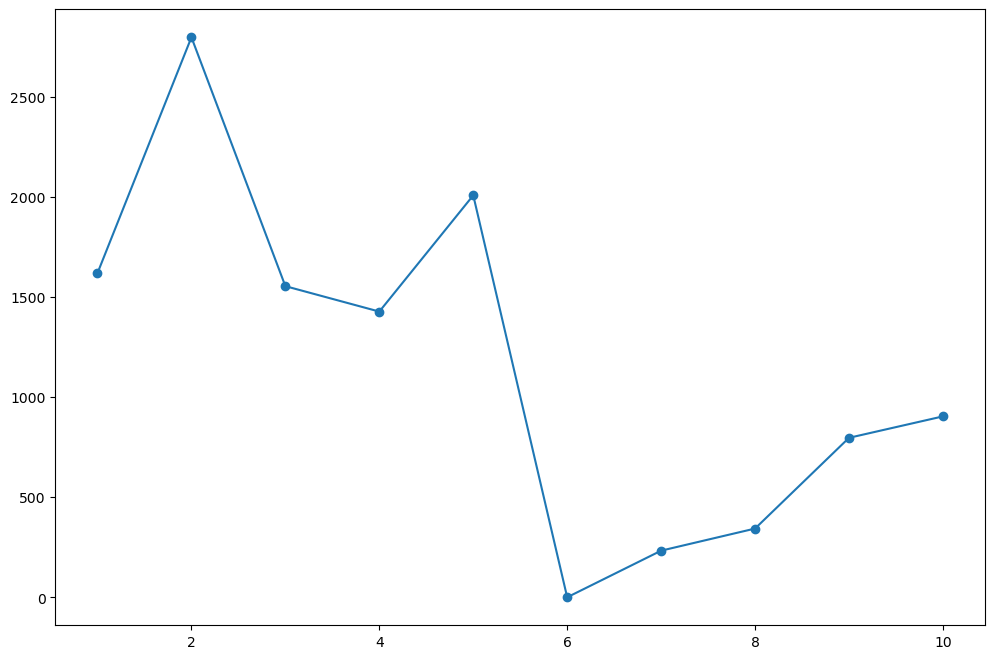

In [22]:
plt.plot(complexities, ubic_plot-min(ubic_plot), '-o'); plt.show()

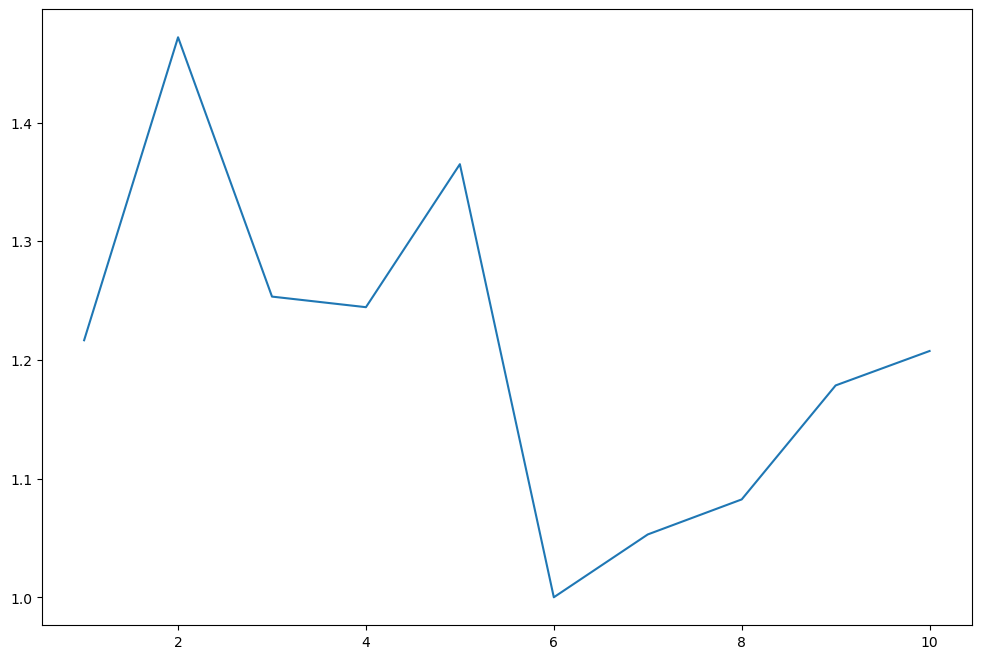

In [23]:
plt.plot(complexities, uncertainties); plt.show()

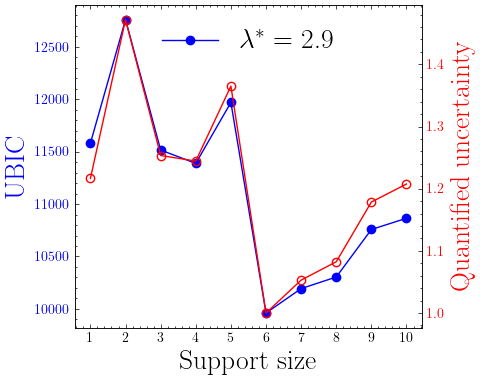

In [24]:
import scienceplots
fs = 20
with plt.style.context('science'):
    fig, ax = plt.subplots(figsize=(5, 4))

    color = 'blue'
    ax.set_xlabel('Support size', fontsize=fs)
    ax.set_ylabel('UBIC', color=color, fontsize=fs)
    ax.plot(complexities, ubic_plot, '-o', color=color, label='$\lambda^{*} = $' + ' ' + str(abs(round(lam_plot, 2))))
    ax.tick_params(axis='y', labelcolor=color)
    ax.set_xticks(complexities)
    # ax.set_title(f"$\epsilon$ = {noise_lv}", fontsize=fs)

    axp = ax.twinx()
    color = 'red'
    axp.set_ylabel('Quantified uncertainty', color=color, fontsize=fs)
    axp.plot(complexities, uncertainties, '-o', color=color, markerfacecolor="None")
    axp.tick_params(axis='y', labelcolor=color)
    
    ax.legend(fontsize=fs, loc='upper center')
    fig.tight_layout()
    # plt.savefig(f"/Users/{getpass.getuser()}/Documents/latex/UBIC-ACML/figures/ks_ubic_noise0-01.pdf")
    # plt.savefig(f"/Users/{getpass.getuser()}/Documents/latex/UBIC-ACML/figures/ks_ubic_noise0-01.png", dpi=300)
    plt.savefig(f"/Users/{getpass.getuser()}/Documents/latex/ML4PS/figures/ks_incomplete_ubic_noise0-01.pdf")
    plt.savefig(f"/Users/{getpass.getuser()}/Documents/latex/ML4PS/figures/ks_incomplete_ubic_noise0-01.png", dpi=300)
    plt.show()

In [25]:
# Computational time
# CPU times: user 1min 25s, sys: 1.58 s, total: 1min 27s
# Wall time: 18.6 s